## 1. Mise en Place de l'Environnement de Travail

In [ ]:
# install Java8
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
# download Spark
!wget -q https://downloads.apache.org/spark/spark-3.1.1/spark-3.1.1-bin-hadoop2.7.tgz
# unzip it
!tar xf spark-3.1.1-bin-hadoop2.7.tgz
# install findspark 
!pip install -q findspark

In [ ]:
# Set up required environment variables

import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.1.1-bin-hadoop2.7"

import findspark

findspark.init("spark-3.1.1-bin-hadoop2.7")

In [ ]:
from pyspark import SparkContext, SparkConf
from pyspark.sql import SparkSession

conf = SparkConf().setAppName("KMeans App").setMaster("local[4]")
sc = SparkContext(conf=conf)
spark = SparkSession(sc)

## 2. Données

### 2.(a) Génération du jeu de données

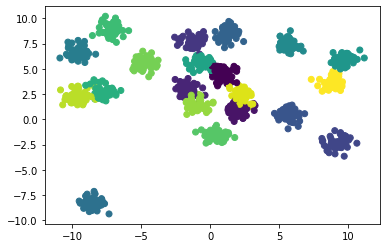

In [ ]:
from sklearn.datasets import make_blobs
import matplotlib.pyplot as plt
import numpy as np
X, y = make_blobs(n_samples=1000, centers=20, cluster_std = 1/2, n_features=2,
                   random_state=0)
plt.scatter(X[:,0], X[:,1],c=y)

### 2.(b) Création du RDD

In [ ]:
data_and_label = np.concatenate([X, np.expand_dims(y, axis=1)], axis=1)

In [ ]:
data_and_label.shape

(1000, 3)

In [ ]:
rdd = sc.parallelize(data_and_label, 4)

### 2.(c)

In [ ]:
from pyspark.sql import Row
names = []
for i in range(1, X.shape[1]+1):
  names.append("X"+str(i))
names.append("classe")

Point = Row(*names)

In [ ]:
rdd_sql = rdd.map(lambda p: Point(*(p[:-1].tolist()), int(p[-1])))

In [ ]:
rdd_sql.count()

1000

### 2. (d)

In [ ]:
df = rdd_sql.toDF()

In [ ]:
df.show()

+--------------------+-------------------+------+
|                  X1|                 X2|classe|
+--------------------+-------------------+------+
|  -8.047948527032977|  8.545460781316905|    13|
|  1.0084305456249232|  8.851920187975772|     6|
|   5.264599533939904| 0.9703771556783387|     5|
|  -1.557717214269729| 2.8642296231875353|     2|
| -0.3540873852091239|  5.774116630289619|    11|
|  -8.608572111609192| -8.416185552934284|     7|
|  1.0605624430497516|    9.2880543558775|     6|
|  -7.193137571151277|  8.153720351010051|    13|
|  -2.132525000084666|   8.01320091201348|     3|
|  0.6060791718439916|-1.3808705693392211|    14|
| -0.6504792019937238|   5.69006286279193|    11|
|   1.449896062433369|  4.226282280902973|     0|
| -0.8575390027409215| 1.6819611027456496|    16|
|   0.901888836969123|  8.638181079391657|     6|
|  -7.584909051355584| 3.5865699128643356|    12|
|0.009346206376001864| -1.078151374775032|    14|
| -2.5422462471126526| 3.9501286920127825|     2|


### 2.(e)

In [ ]:
def generer_Spark_DF_Clusters(nb_samples, nb_clust, nb_features, clust_std=1/2):
  X, y = make_blobs(n_samples=nb_samples, centers=nb_clust, cluster_std = clust_std, n_features=nb_features)
  data_and_label = np.concatenate([X, np.expand_dims(y, axis=1)], axis=1)
  rdd = sc.parallelize(data_and_label, 4)
  names = []
  for i in range(1, X.shape[1]+1):
    names.append("X"+str(i))
  names.append("classe")

  Point = Row(*names)
  rdd_sql = rdd.map(lambda p: Point(*(p[:-1].tolist()), int(p[-1])))
  df = rdd_sql.toDF()
  return df, X, y

In [ ]:
df_4cl_2f, _, _ = generer_Spark_DF_Clusters(1000, 3, 2, 1/2)

In [ ]:
df_4cl_2f.show()

+-------------------+------------------+------+
|                 X1|                X2|classe|
+-------------------+------------------+------+
| -2.574564871425908| 3.690121055930046|     2|
|  5.508177323016732| 5.725516333242662|     0|
| -1.712595836452459|3.2182628818554098|     2|
|  4.682249202751663| 5.902589788874676|     0|
|   9.59304141201762| 7.794400589627484|     1|
|-1.7259187285657265|3.9180579065064842|     2|
| -2.301379342291364|2.8683076625620947|     2|
|  9.910986341610707| 7.780930114592386|     1|
|  5.097640131707814| 6.808966890719561|     0|
|-1.6950488610684178|  2.69252870473918|     2|
| -2.336803942308668|2.2873859617967507|     2|
|  4.212171039539251| 5.569935464119045|     0|
|-1.6906052878541076| 3.387798334296808|     2|
|  5.246634441629115| 6.397481748518658|     0|
|  9.501609469052594|  6.38598779843693|     1|
|  8.888577131310576| 8.005792608761205|     1|
| -2.077040568475145| 4.179588125654967|     2|
| 4.3520966180899565| 6.347294774211181|

## Analyse Descriptive

### 3.(a) Vérifier le nombre de classes

In [ ]:
df.select("classe").distinct().count()

3

### 3.(b) Vérifier le nombre de points

In [ ]:
df.count()

1000

### 3.(c) Voir la variance des classes

In [ ]:
from pyspark.sql.functions import var_pop

In [ ]:
from pyspark.sql.functions import col
df_var = df.groupBy('classe').agg({x:"var_pop" for x in df.columns if x!="classe"})
cols_obj = None
for c in df_var.columns[1:]:
  if cols_obj is None:
    cols_obj = col(c)
  else:
    cols_obj += col(c)
cols_obj/=len(df_var.columns[1:])

df_classe_var=df_var.withColumn("classe_variance", cols_obj).select("classe","classe_variance")
df_classe_var.sort("classe").show()

+------+-------------------+
|classe|    classe_variance|
+------+-------------------+
|     0|0.24364724066886623|
|     1| 0.2288226458007518|
|     2| 0.2394487754256415|
+------+-------------------+



In [ ]:
df_classe_var.rdd.collect()

[Row(classe=0, classe_variance=0.24364724066886623),
 Row(classe=1, classe_variance=0.22882264580075173),
 Row(classe=2, classe_variance=0.23944877542564147)]

In [ ]:
df_classe_var.agg({"classe_variance":"sum"}).show()

+--------------------+
|sum(classe_variance)|
+--------------------+
|  0.7119186618952594|
+--------------------+



### Centres des classes

In [ ]:
df.columns

['X1', 'X2', 'classe']

In [ ]:
df.groupBy('classe').agg({x:"mean" for x in df.columns if x!="classe"}).sort("classe").show()


+------+------------------+------------------+
|classe|           avg(X1)|           avg(X2)|
+------+------------------+------------------+
|     0|0.9173256324645449| 4.279705428862379|
|     1|2.0914985089519735|0.8827713616465471|
|     2|-1.545927103338693|2.9344944534061694|
+------+------------------+------------------+



### Nombre d'éléments par classe

In [ ]:
df.groupby("classe").count().sort("classe").show()

+------+-----+
|classe|count|
+------+-----+
|     0|  334|
|     1|  333|
|     2|  333|
+------+-----+



## Clustering avec Implémentations Disponibles

### 4. implémentation manuelle

In [ ]:
import numpy as np

In [ ]:
def closest_clusters(X, clusters):
  distances = np.sqrt(((X - clusters[:, np.newaxis])**2).sum(axis=2))
  return np.argmin(distances, axis=0)
def move_centroids(points, closest, centroids):
    return np.array([points[closest==k].mean(axis=0) for k in range(centroids.shape[0])])

In [ ]:
def kmeans(X, nb_clust, nbit=100):
  it = 0
  CONVERGE = False
  # initialiser les clusters
  choice_ind = np.random.choice(np.arange(0, X.shape[0]), replace=False, size=nb_clust)
  for i, ind in enumerate(choice_ind):
    if i==0:
      clusters = np.copy(X[ind,:])
    else:
      clusters = np.vstack((clusters, X[ind,:]))
  while not CONVERGE and it <nbit:
    closest = closest_clusters(X, clusters)
    clust = move_centroids(X, closest, clusters)

    it+=1 
  return closest, clust


In [ ]:
%%time
nb_clust = df.select("classe").distinct().count()
closest, clust = kmeans(X, nb_clust, 10)

CPU times: user 26.6 ms, sys: 8.45 ms, total: 35.1 ms
Wall time: 1.21 s


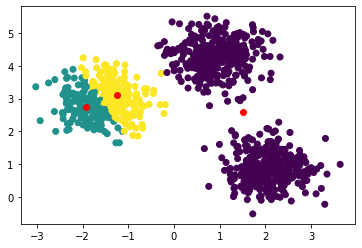

In [ ]:
plt.scatter(X[:,0], X[:,1], c=closest)
plt.scatter(clust[:,0], clust[:,1], color="red")
plt.show()

### 4. sklearn

#### Exemple 1

In [ ]:
from sklearn.cluster import KMeans
import time
nb_clust = 20
n_features = 2
times_sklearn = []
SHOW_PLOTS = False
n_obs_list = [1000, 2000, 5000, 7000, 10000, 20000, 50000, 70000, 100_000, 200_000, 500_000, 700_000, 1_000_000]
liste_exemples = []
for nb_obs in n_obs_list:
  print(nb_obs, end=" : ")
  dfb, Xb, yb = generer_Spark_DF_Clusters(nb_obs, nb_clust, n_features, clust_std=1/2)
  liste_exemples.append((dfb, Xb, yb))
  START_TIME = time.time()
  kmeans = KMeans(n_clusters=nb_clust).fit(Xb)
  times_sklearn.append(time.time() - START_TIME)
  print(times_sklearn[-1])
  pred_sklearn = kmeans.predict(Xb)
  if SHOW_PLOTS:
    plt.scatter(Xb[:,0], Xb[:,1], c=pred_sklearn)
    plt.scatter(kmeans.cluster_centers_[:,0], kmeans.cluster_centers_[:,1], color="red")
    plt.show()

1000 : 0.13587284088134766
2000 : 0.26703619956970215
5000 : 0.38715124130249023
7000 : 0.5998826026916504
10000 : 0.40062880516052246
20000 : 0.6905465126037598
50000 : 1.5052828788757324
70000 : 2.3114473819732666
100000 : 2.92840838432312
200000 : 7.422567367553711
500000 : 11.832081317901611
700000 : 18.46713948249817
1000000 : 30.829277753829956


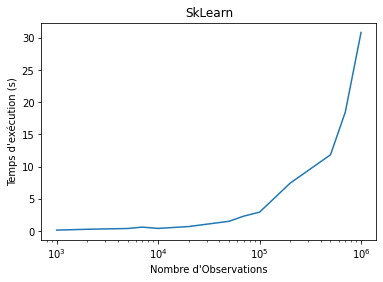

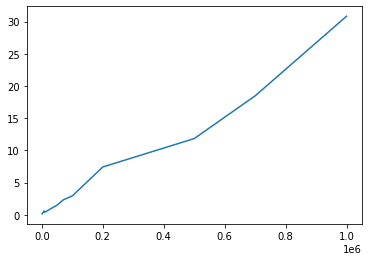

In [ ]:
plt.plot(n_obs_list, times_sklearn)
plt.xscale("log")
plt.title("SkLearn")
plt.ylabel("Temps d'exécution (s)")
plt.xlabel("Nombre d'Observations")
plt.show()

plt.plot(n_obs_list, times_sklearn)
plt.show()

### 4. Spark : DF

In [ ]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.clustering import KMeans

spark_mllib_times = []
ii = 0
for dfs, _, _ in liste_exemples:
  print(ii, end=" : ")
  vecAssembler = VectorAssembler(inputCols=dfs.columns[:-1], outputCol="features")
  df_kmeans = vecAssembler.transform(dfs).select('features', "classe")
  #df_kmeans.show()

  KMeans_algo=KMeans(k=nb_clust)

  START_SPARK_MLLIB = time.time()
  KMeans_fit=KMeans_algo.fit(df_kmeans.select("features"))
  spark_mllib_times.append(time.time() - START_SPARK_MLLIB)
  print(spark_mllib_times[-1])

  output=KMeans_fit.transform(df_kmeans.select("features"))
  ii+=1

0 : 9.221327781677246
1 : 3.2917490005493164
2 : 3.7975733280181885
3 : 3.1981706619262695
4 : 2.693068265914917
5 : 3.777836799621582
6 : 4.951326370239258
7 : 5.464320182800293
8 : 8.823617696762085
9 : 10.901595830917358
10 : 24.351922750473022
11 : 31.966198921203613
12 : 48.63465619087219


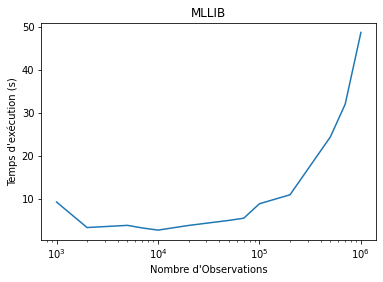

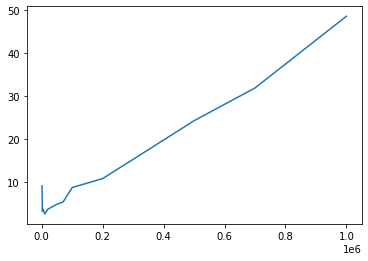

In [ ]:
plt.plot(n_obs_list, spark_mllib_times)
plt.xscale("log")
plt.title("MLLIB")
plt.ylabel("Temps d'exécution (s)")
plt.xlabel("Nombre d'Observations")
plt.show()

plt.plot(n_obs_list, spark_mllib_times)
plt.show()

In [ ]:
speedups = [y/x for x,y in zip(spark_mllib_times, times_sklearn)]
speedups

[0.01473462868886698,
 0.08112289227554714,
 0.10194700875059337,
 0.18757054144519572,
 0.1487629594210887,
 0.18278886813557704,
 0.3040160890874568,
 0.4230073100856843,
 0.3318829628574829,
 0.6808697994933013,
 0.48587873077380633,
 0.5777083327304412,
 0.6338952542984365]

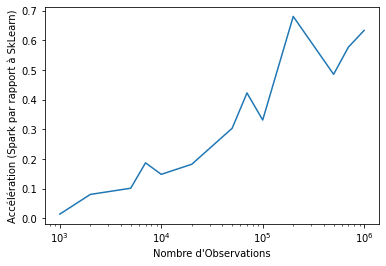

In [ ]:
plt.plot(n_obs_list, speedups)
plt.xscale("log")
plt.ylabel("Accélération (Spark par rapport à SkLearn)")
plt.xlabel("Nombre d'Observations")
plt.show()

In [ ]:
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator

silhouette_score=[]
evaluator = ClusteringEvaluator(predictionCol='prediction', featuresCol='features', \
                                metricName='silhouette', distanceMeasure='squaredEuclidean')
for i in range(5,15):
    KMeans_algo=KMeans(k=i)
    
    KMeans_fit=KMeans_algo.fit(df_kmeans.select("features"))
    
    output=KMeans_fit.transform(df_kmeans.select("features"))
    
    
    
    score=evaluator.evaluate(output)
    
    silhouette_score.append(score)
    
    print(f"Score silhouette {i} : {score}")

Score silhouette 5 : 0.7421141497350456
Score silhouette 6 : 0.5979668621933625
Score silhouette 7 : 0.5927684588615709
Score silhouette 8 : 0.49033831724712607
Score silhouette 9 : 0.486627994333032
Score silhouette 10 : 0.505479634010024
Score silhouette 11 : 0.5035631775937017
Score silhouette 12 : 0.4757657698167345
Score silhouette 13 : 0.4763541242257323
Score silhouette 14 : 0.4615260813543873


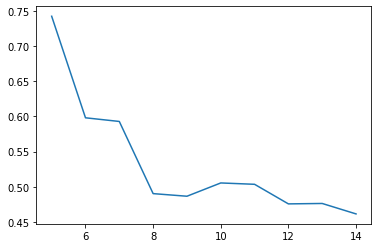

In [ ]:
plt.plot(list(range(5, 15)), silhouette_score)

In [ ]:
%%time
KMeans_algo=KMeans(k=nb_clust)
    
KMeans_fit=KMeans_algo.fit(df_kmeans.select("features"))

output=KMeans_fit.transform(df_kmeans.select("features"))

CPU times: user 58.4 ms, sys: 15.5 ms, total: 74 ms
Wall time: 2.03 s


In [ ]:
spark_kmeans_centroids = np.array(KMeans_fit.clusterCenters())

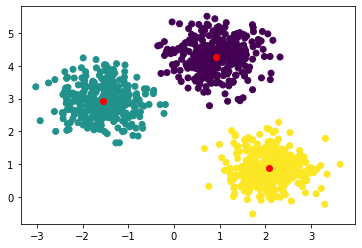

In [ ]:
plt.scatter(df.select("X1").collect(), df.select("X2").collect(), c=output.select("prediction").collect())
plt.scatter(spark_kmeans_centroids[:,0], spark_kmeans_centroids[:,1], color="red")
plt.show()

## 5. Evaluate clusterings

### Sklearn KMeans

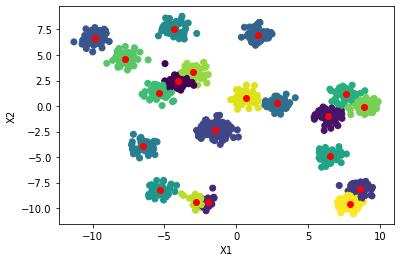

In [ ]:
from sklearn.cluster import KMeans
nb_cls = 20
dfs, Xs, ys = generer_Spark_DF_Clusters(1000, nb_cls, 2, clust_std=1/2)
liste_exemples.append((dfs, Xs, ys))
kmeans = KMeans(n_clusters=nb_cls).fit(Xs)

pred_sklearn = kmeans.predict(Xs)
plt.scatter(Xs[:,0], Xs[:,1], c=pred_sklearn)
plt.scatter(kmeans.cluster_centers_[:,0], kmeans.cluster_centers_[:,1], color="red")
plt.xlabel("X1")
plt.ylabel("X2")
plt.show()

In [ ]:
from sklearn.metrics.cluster import normalized_mutual_info_score
normalized_mutual_info_score(ys, pred_sklearn)

0.9454447272096195

### Spark KMeans

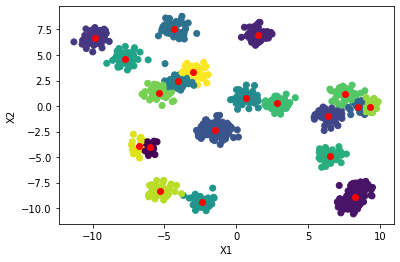

In [ ]:
from pyspark.ml.clustering import KMeans
vecAssembler = VectorAssembler(inputCols=dfs.columns[:-1], outputCol="features")
df_kmeans = vecAssembler.transform(dfs).select('features', "classe")

KMeans_algo=KMeans(k=nb_cls)

KMeans_fit=KMeans_algo.fit(df_kmeans.select("features"))

output=KMeans_fit.transform(df_kmeans.select("features"))

spark_kmeans_centroids = np.array(KMeans_fit.clusterCenters())

plt.scatter(dfs.select("X1").collect(), dfs.select("X2").collect(), c=output.select("prediction").collect())
plt.scatter(spark_kmeans_centroids[:,0], spark_kmeans_centroids[:,1], color="red")
plt.xlabel("X1")
plt.ylabel("X2")
plt.show()

In [ ]:
vrais_labels = dfs.select("classe").rdd.map(lambda x: x.classe).collect()
preds_spark_kmeans = output.select("prediction").rdd.map(lambda x: x.prediction).collect()
normalized_mutual_info_score(vrais_labels, preds_spark_kmeans)

0.9384826210314254

## 7. Implémentation de KMeans Distribué

In [ ]:
X.shape

(1000, 2)

In [ ]:
from pyspark.ml.feature import VectorAssembler

vecAssembler = VectorAssembler(inputCols=df.columns[:-1], outputCol="features")
df_kmeans = vecAssembler.transform(df).select('features', "classe")
df_kmeans.show()

+--------------------+------+
|            features|classe|
+--------------------+------+
|[-8.0479485270329...|    13|
|[1.00843054562492...|     6|
|[5.26459953393990...|     5|
|[-1.5577172142697...|     2|
|[-0.3540873852091...|    11|
|[-8.6085721116091...|     7|
|[1.06056244304975...|     6|
|[-7.1931375711512...|    13|
|[-2.1325250000846...|     3|
|[0.60607917184399...|    14|
|[-0.6504792019937...|    11|
|[1.44989606243336...|     0|
|[-0.8575390027409...|    16|
|[0.90188883696912...|     6|
|[-7.5849090513555...|    12|
|[0.00934620637600...|    14|
|[-2.5422462471126...|     2|
|[5.59948432030285...|     5|
|[1.87827056580613...|     1|
|[-1.8897027024536...|     2|
+--------------------+------+
only showing top 20 rows



### 7.(a) compute_centroids

In [ ]:
def compute_centroids(points, cluster_ids):
  ## i
  sum_by_cluster_id = cluster_ids.zip(points.map(lambda x: np.array(x))).reduceByKey(lambda x,y: x+y)
  ## ii
  count_by_cluster_id = cluster_ids.map(lambda x:(x, 1)).reduceByKey(lambda x,y: x+y)
  # iii
  mean_by_cluster_id = sum_by_cluster_id.join(count_by_cluster_id).mapValues(lambda x: x[0] / x[1])#.sortByKey()
  return mean_by_cluster_id

compute_centroids(df_kmeans.select("features").rdd.map(lambda x: x.features), df_kmeans.select("classe").rdd.map(lambda x: x.classe)).collect()

[(0, array([0.90235168, 4.42185825])),
 (16, array([-0.92463911,  1.4360876 ])),
 (12, array([-7.68094278,  2.73094844])),
 (4, array([ 9.21533194, -2.33047443])),
 (8, array([-9.61130711,  6.59276063])),
 (13, array([-7.16297578,  8.93500311])),
 (5, array([5.74359681, 0.45020039])),
 (1, array([2.01690177, 0.86786425])),
 (17, array([-9.64253461,  2.31465558])),
 (9, array([5.61344124, 7.47507836])),
 (6, array([1.29459316, 8.5059329 ])),
 (2, array([-1.62005032,  2.92131576])),
 (14, array([ 0.40133683, -1.62656084])),
 (10, array([9.69655323, 5.93009198])),
 (18, array([2.28836104, 2.2683736 ])),
 (11, array([-0.61089901,  5.61479085])),
 (7, array([-8.56374582, -8.30677461])),
 (3, array([-1.30105616,  7.73340856])),
 (19, array([8.84539254, 3.62725194])),
 (15, array([-4.7778082 ,  5.57250056]))]

### 7.(b) assign_clusters

In [ ]:
def squared_distances(point, centroids):
  centroids = np.array(centroids)
  if isinstance(point, (int, float, complex)) and not isinstance(point, bool):
    expr = np.expand_dims(((centroids - point)**2), axis=1)
  else:
    expr = (centroids - point)**2
  return expr.sum(axis=1)

In [ ]:
squared_distances([1,2], [[1,2], [3,4], [5,6]])

array([ 0,  8, 32])

In [ ]:
import numpy as np

In [ ]:
def assign_clusters(points, centroids):
  ## i
  centr = centroids.map(lambda x: x[1]).collect()
  liste_centroids = sc.broadcast(centr)
  
  ## ii et iii
  assignations_rdd = points.map(lambda x: np.argmin(squared_distances(np.array(x), liste_centroids.value)))
  return assignations_rdd
pts = df_kmeans.select("features").rdd.map(lambda x: x.features)
cin = compute_centroids(pts, df_kmeans.select("classe").rdd.map(lambda x: x.classe))
assign = assign_clusters(pts, cin)
assign.count()

1000

### 7.(c) Initialisation

In [ ]:
from pyspark.sql import functions as F
def initialize_centroids(points, nclusters):
  rdd = sc.parallelize([(i,np.array(x)) for i, x in enumerate(points.takeSample(withReplacement=False, num=nclusters))])
  return rdd.map(lambda x: (x[0],x[1]))
   
initialize_centroids(df_kmeans.select("features").rdd.map(lambda x: x.features), 3).collect()

[(0, array([ 5.63830626, -0.94517313])),
 (1, array([2.48368283, 0.57215086])),
 (2, array([-1.60573752,  4.04624401]))]

In [ ]:
points = df_kmeans.select("features").rdd.map(lambda x: x.features)
NB_IT = 10

In [ ]:
%%time
centroids = initialize_centroids(points, 3)
for i in range(NB_IT):
  cluster_ids = assign_clusters(points, centroids)
  centroids = compute_centroids(points, cluster_ids)

  print(f"Itération {i}")

Itération 0
Itération 1
Itération 2
Itération 3
Itération 4
Itération 5
Itération 6
Itération 7
Itération 8
Itération 9
CPU times: user 560 ms, sys: 48.4 ms, total: 608 ms
Wall time: 9.51 s


In [ ]:
from pyspark.ml.feature import VectorAssembler
import time

points = df_kmeans.select("features").rdd.map(lambda x: x.features)

def kmeans_spark_new(points, k, NB_IT=10):
  centroids = initialize_centroids(points, k)
  for i in range(NB_IT):
    cluster_ids = assign_clusters(points, centroids)
    centroids = compute_centroids(points, cluster_ids)
  return cluster_ids, centroids

In [ ]:
start_t = time.time()
cid, cent = kmeans_spark_new(points, 20)
cid, cent = cid.collect(), cent.collect()
print(f"L'exécution a pris {time.time()-start_t}")

L'exécution a pris 8.52432656288147


In [ ]:
centcl = [x[1] for x in cent]

In [ ]:
from sklearn.metrics.cluster import normalized_mutual_info_score
vrais_labels = df.select("classe").rdd.map(lambda x: x.classe).collect()
preds_spark_kmeans = cid
normalized_mutual_info_score(vrais_labels, preds_spark_kmeans)

0.9409338450648373

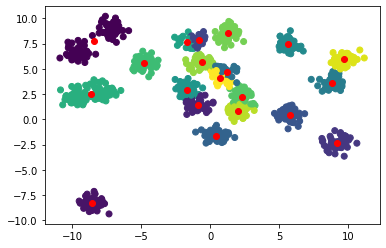

In [ ]:
spark_kmeans_centroids = np.array(centcl)
plt.scatter(df.select("X1").collect(), df.select("X2").collect(), c=cid)
plt.scatter(spark_kmeans_centroids[:,0], spark_kmeans_centroids[:,1], color="red")
plt.show()

# Distributed KMeans : Version Optimisée

In [ ]:
def closest_clusters_map(x):
  dist = ((x - clusters_actuels.value[:, np.newaxis])**2).sum(axis=2)
  return (np.argmin(dist, axis=0)[0],x)

In [ ]:
%%time
nb_clusters = 3
nb_iter = 10
CONVERGE = False
rdd = sc.parallelize(X, 4)
choice_ind = np.random.choice(np.arange(0, X.shape[0]), replace=False, size=nb_clusters)
for i, ind in enumerate(choice_ind):
  if i==0:
    clusters = np.copy(X[ind,:])
  else:
    clusters = np.vstack((clusters, X[ind,:]))
it=0
while not CONVERGE and it < nb_iter:
  clusters_actuels = sc.broadcast(clusters)
  rdd2 = rdd.map(closest_clusters_map)
  rdd3 = rdd2.map(lambda x: (x[0],(x[1], 1)))
  rdd4 = rdd3.reduceByKey(lambda x, y: (x[0]+y[0], x[1]+y[1]))
  rdd5 = rdd4.map(lambda x: x[1][0]/x[1][1])
  clusters = np.array(rdd5.collect())

  it+=1
closest = rdd2.map(lambda x:x[0]).collect()
clust = clusters

CPU times: user 172 ms, sys: 19.6 ms, total: 192 ms
Wall time: 1.75 s


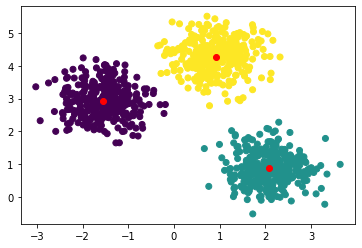

In [ ]:
plt.scatter(X[:,0], X[:,1], c=closest)
plt.scatter(clust[:,0], clust[:,1], color="red")
plt.show()

# BONUS : 11. Application sur un cas Pertinent
Nous allons appliquer l'algorithme développé sur du clustering de mots par thèmes. Nous nous baserons sur des Embeddings BERT BASE de 768. Et travaillerons sur un ensemble de 583 mots appartenant à 3 thèmes : 
- BOTANIQUE
- CORS HUMAIN
- GEOGRAPHIE

Nous disposons des vrais labels que nous utiliserons afin de valider les résultats.
Ces données nous ont été transmises dans le cadre du projet DATA 2.

In [ ]:
mat['layer_01'].shape

(583, 768)

## Importation des Données

In [ ]:
import scipy.io
mat = scipy.io.loadmat('/content/drive/MyDrive/bigdata/word_representations__bert-base-cased__Data1.mat')

Nous travaillerons dans notre cas avec une concaténation des représentations des 4 dernières couches de BERT (comme recommandé par les auteurs de BERT)

In [ ]:
l_concat = np.concatenate([mat["layer_09"], mat["layer_10"],mat["layer_11"], mat["layer_12"]], axis=1)

In [ ]:
words = mat["words"]
new_words = ["" if np.random.random()>0.2 else word for word in words]

## Visualisation des mots par TSNE

In [ ]:
import numpy as np
from sklearn.manifold import TSNE
X_embedded = TSNE(n_components=2).fit_transform(l_concat)
import plotly.express as px
fig = px.scatter(x=X_embedded[:,0], y=X_embedded[:,1], text=new_words, color=mat["real_class"])
fig.show()

In [ ]:
%%time
nb_clusters = 3
nb_iter = 20
CONVERGE = False
rdd = sc.parallelize(l_concat, 4)
choice_ind = np.random.choice(np.arange(0, l_concat.shape[0]), replace=False, size=nb_clusters)
for i, ind in enumerate(choice_ind):
  if i==0:
    clusters = np.copy(l_concat[ind,:])
  else:
    clusters = np.vstack((clusters, l_concat[ind,:]))
it=0
while not CONVERGE and it < nb_iter:
  clusters_actuels = sc.broadcast(clusters)
  rdd2 = rdd.map(closest_clusters_map)
  rdd3 = rdd2.map(lambda x: (x[0],(x[1], 1)))
  rdd4 = rdd3.reduceByKey(lambda x, y: (x[0]+y[0], x[1]+y[1]))
  rdd5 = rdd4.map(lambda x: x[1][0]/x[1][1])
  clusters = np.array(rdd5.collect())

  it+=1
  if it%10==0:
    print(f"Itération {it}")
closest = rdd2.map(lambda x:x[0]).collect()
clust = clusters

Itération 10
Itération 20
CPU times: user 480 ms, sys: 63.9 ms, total: 544 ms
Wall time: 4.49 s


In [ ]:
fig = px.scatter(x=X_embedded[:,0], y=X_embedded[:,1], text=new_words, color=closest)
fig.show()

## Evaluation

In [ ]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
vrais_labels_mots = le.fit_transform(mat["real_class"])

In [ ]:
normalized_mutual_info_score(vrais_labels_mots, closest)

0.9265149065818871

In [ ]:
from sklearn.metrics.cluster import adjusted_rand_score, contingency_matrix
adjusted_rand_score(vrais_labels_mots, closest)

0.9624302030027443

In [ ]:
contingency_matrix(vrais_labels_mots, closest)

array([[  2,   2, 262],
       [  0,  88,   2],
       [225,   2,   0]])